# Text Generator Model Training

## Note:
- This notebook serves as the main notebook of the project in terms of its details of related concepts and model training, for the other two notebooks for training models have identical structures of processes.
- For details of the models for the other two age groups, please refer to their corresponding training notebooks
- For preprocessing, please refer to **(1) Initial analysis of dataset.ipynb** and the three notebooks with the prefix `Preprocessing` inside the folder named `Initial processing`.
- For further conclusion of all three models, please refer to **Model comparison and conclusion.ipynb**
- The numbering of the original jupyter notebook file is not ordered consecutively due to various changes made during the modelling. For reading convenience in its .pdf file, the number orders of cells have been changed using Latex.

## Introduction
Considering the great size of the original dataset and time as well as computing power constraints, only a sample of it was used to train the model. Samples of two different sizes were generated for each age group's dataset: one of the length 10,000 (sentences) and one of the length 5,000 (sentences). 

At first, our group focus on finding a way to train the larger sample (with 10,000 sentences). After several experiments, we discover that there are two main ways of doing so: 

(1) using CPU to train all 10,000 observations all at once, which takes over 5 minutes for each epoch. 
Considering that the models need a lot of adjustments and we don't have much time, this approach was not considered.

(2) using GPU to train the 10,000 observations in 'batches' (i.e. first train the first 3,000 instances, then train the next 3,000 instances, and so on), for, the GPU, although can speed up the training a lot, has limitations on the training data size due to a memory allocation issue.
As shown in **(3.1.1) Multi Batch GPU-Under_20.ipynb** inside the folder `Multi Batch Trial`, this approach did not produce satisfying results, which is possibly caused by the small data size and the nature of the original dataset (for more details please refer to the said file).

Therefore, we later turn to train the second sample which is half the size of the first one, as it is the limit of our GPU without encountering any issues.

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

import numpy as np 
import pandas as pd

import io
import json
import random
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## I. Tokenization

To prepare the text for the model training, its words need to be encoded first using a process called **tokenization**. Tokenization creates a vocabulary index based on word frequency. 
It will create a dictionary in which every word of the input text gets a unique integer value (0 is reserved for padding). Lower integer means more frequent word (often the first few are stop words because they appear a lot). Later, each piece of text is transformed to a sequence of integers, according to the dictionary created above. 

Below is a simple example of tokenization of two sentences that have some words in common:

|          |              |        |      |         |          |            |            |
|----------|:------------:|:------:|:----:|:-------:|:--------:|:----------:|:----------:|
| Text #1  |      Natural     | Language |  Processing | is | super | fun |            |
| Index #1 |      1      |   2   |  3  |    4   |    5    |     6     |            |
| Text #2  | Tokenization |   is   | used |    in   |  Natural |  Language  | Processing |
| Index #2 |      7      |   4   |  8  |    9   |    1    |     2     |     3     |

In this short example, it can be seen that the words "Natural", "Language", "Processing", and "is" have the same index in the two sentences, while the other words are assigned with other integers for their representations.

In [2]:
# Create an instance object of the tokenizer
tokenizer = Tokenizer()

data = pd.read_csv('../../Data/sample2_under_20.csv')
print("Number of sentences in the dataset:", data.shape[0])

corpus = data['0'].tolist()
del data

# Tokenize the sentences
tokenizer.fit_on_texts(corpus)

# To define the total number of words for machine processing, 1 is 
# added to the word index of the tokenizer created for the text 
# due to the inclusion of '0' used in padding
total_words = len(tokenizer.word_index) + 1

print('There are %d unique words in total' %(total_words-1))

Number of sentences in the dataset: 5000
There are 10663 unique words in total


In [4]:
# Save tokenizer
tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

## II. n-gram and Padding
As the model is intended to generate text, it's essentially performing predictions on a word-by-word basis, meaning that it should be able to predict the next word based on the previous words. Therefore, the concept of **n-gram** is involved in the preprocessing, which is basically taking subsets of different lengths of the same sentences so that they can be later treated as different training instances.

For example, for the sentence "NLP stands for Natural Language Processing," it will be divided into the following subsets (the following table is using actual words to better illustrate, while the machine will perform this step using their word indices):

|     |        |     |         |          |            |
|:---:|:------:|:---:|:-------:|:--------:|:----------:|
| Natural | Language |     |         |          |            |
| Natural | Language | Processing |         |          |            |
| Natural | Language | Processing | is |          |            |
| Natural | Language | Processing | is | super |            |
| Natural | Language | Processing | is | super | fun |

In this way, these subsets will be later divided into predictors (the first until the second-to-last words) and target outputs (the last words) for model training.

**Padding** is a way to standardise the lengths of the text, after the masking is completed with the tokenizer above. 
Basically, it just adds as many 0s as needed to the end (or front) of each text, to match the longest sentence.

Below is a simple example of padding using the two sentences above. As the second sentence is the longer one, only the first sentence will need padding, and only one 0 will be enough for its padding. This 0 can be added to the end or the front of text #1, and in this case, it's added to the front of the sentence:

|          |              |        |      |         |          |            |            |
|----------|:------------:|:------:|:----:|:-------:|:--------:|:----------:|:----------:|
| Text #1  |      Natural     | Language |  Processing | is | super | fun |            |
| Index #1 |      1      |   2   |  3  |    4   |    5    |     6     |            |
| Padded text #1 | 0      |   1   |  2  |    3   |    4  |    5     |    6       |
| Text #2  | Tokenization |   is   | used |    in   |  Natural |  Language  | Processing |
| Index #2 |      7      |   4   |  8  |    9   |    1    |    2     |     3    |

In [3]:
input_sequences = []
for line in corpus: # iterate through the list of sentences
    # For each sentence, use the tokenizer to encode it into 
    # a sequence of numbers (word indices)
    token_list = tokenizer.texts_to_sequences([line])[0]
    
    for i in range(1, len(token_list)): # iterate through the word 
                                        # indices of the sentence
        n_gram_sequence = token_list[:i+1] # create subset of the sentence
        input_sequences.append(n_gram_sequence)

# Determine the largest length of all sentences
max_sequence_len = max([len(x) for x in input_sequences]) 
print('The longest sentence has %d words' %max_sequence_len)

# Pad sequences (to the front)
input_sequences = np.array(pad_sequences(input_sequences, 
                                         maxlen=max_sequence_len, padding='pre'))

# Create predictors and labels
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

# One-hot encode the labels (target output)
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

The longest sentence has 35 words


## III. Other preparations: functions

In [6]:
# Plot accuracy/loss graphs after model training finishes
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.title(string + " changes over epochs")
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

In [7]:
def text_generator(seed_text, next_words, tokenizer, 
                   model, max_sequence_len):
    '''
    Returns a block of text generated using a trained model.
    
    Parameters:
        seed_text (str): several words to start the block of text
        next_words (int): number of generated words desired
        tokenizer: tokenizer of the trained model
        model: trained model for text generation
        max_sequence_len: the biggest length of the sentences fed to the model
    '''
    for w in range(next_words):
        # Tokenize the previous words (i.e. the starting words when the 
        # text generation first begins)
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        # Pad sequences
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, 
                                   padding='pre')
        # Generate model predictions based on the padded sequences
        predicted = model.predict_classes(token_list, verbose=0)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            # Look for the corresponding word of the predicted word index 
            # output by the model above
            if index == predicted:
                output_word = word
                break
        # Add the predicted word
        seed_text += " " + output_word
    return seed_text

## IV. Model Training
### i. Word Embedding
After different words are encoded using word indices (tokenization), the machine is able to process them. However, another issue remains that the machine is unable to capture the meanings. Therefore, the method of **embedding** is used to represent each word as a vector so that words having similar meanings can be represented as vectors close to each other in the vector space. 

### ii. Recurrent Neural Network (RNN)
When encountered with data involving "contexts", such as time-series data or language-related data, traditional neural networks are usually very ineffective, for they are unable to utilize the previous information for the next prediction. In comparison, **Recurrent Neural Network** proves to be much more effective in training these types of data, for it can additionally "memorize" the previous information and use it later. Essentially, RNN maintains an internal state about the steps it has seen so far, which enables it to retain some 'context' that is useful for time-series and Natural Language Processing. 

**Long Short Term Memory networks (LSTM)** are a type of RNN which tries to manage short and long term memory efficiently, by forgetting unimportant events after certain periods. LSTM also has further variations, one of which, called **Bidirectional LSTM**, is also used in this project. Bidirectionality refers to a model which runs on both the as-is as well as reversed versions of the sequence. 

For more details regarding RNN and LSTM, one can refer to resources such as https://colah.github.io/posts/2015-08-Understanding-LSTMs/

### Notes:
For simplicity, only two models are shown in this notebook, the first one being the initial model and the second being the final model after several tunings. Both models involve using an Embedding layer in the beginning and a Dense layer with the softmax activation function in the end. The tunings (the detailed steps are not shown in here) involve adjusting:
- the number of *layers in between and their node numbers*
- the usage of *Dropout layers*
- the usage of *regularization*
- the type of *optimizer*
- the value of *learning rate*

### (1) Initial model

In [11]:
# Construct the initial model
model = Sequential()
model.add(Embedding(total_words, 150, # the vectors representing words have
                                      # a length of 150
                    input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(200, return_sequences = True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(200)))
model.add(Dropout(0.2))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics=['accuracy'])

# Save the model
filepath = "model_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, 
                             save_best_only=True, mode='min')
desired_callbacks = [checkpoint]

history = model.fit(xs, ys, epochs=30, batch_size=64, verbose=1, 
                    callbacks=desired_callbacks)

print(model)
print(model.summary())

Epoch 1/30
1214/1214 [==============================] - 47s 29ms/step - loss: 8.2462 - accuracy: 0.0298

Epoch 00001: loss improved from inf to 8.24624, saving model to model_weights2.hdf5
Epoch 2/30
1214/1214 [==============================] - 37s 30ms/step - loss: 9.4944 - accuracy: 0.0288

Epoch 00002: loss did not improve from 8.24624
Epoch 3/30
1214/1214 [==============================] - 37s 31ms/step - loss: 9.4619 - accuracy: 0.0332

Epoch 00003: loss did not improve from 8.24624
Epoch 4/30
1214/1214 [==============================] - 36s 30ms/step - loss: 8.8561 - accuracy: 0.03760s - los

Epoch 00004: loss did not improve from 8.24624
Epoch 5/30
1214/1214 [==============================] - 36s 29ms/step - loss: 8.3087 - accuracy: 0.0438

Epoch 00005: loss did not improve from 8.24624
Epoch 6/30
1214/1214 [==============================] - 36s 30ms/step - loss: 7.9091 - accuracy: 0.0471

Epoch 00006: loss improved from 8.24624 to 7.90909, saving model to model_weights2.hdf5
Ep

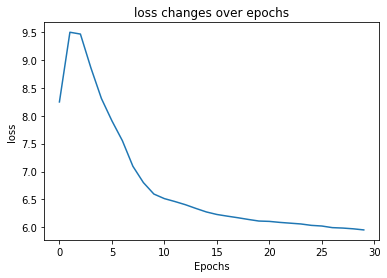

In [13]:
plot_graphs(history, 'loss')

The plot above shows the changes of training losses over the 30 epochs. It can be seen that the losses first increase in the first 3 epochs, which then decreased rapidly until epoch 10. Afterwards, the losses decreased slowly became stable when it approaches 30 epochs.

In [14]:
print(text_generator('i was home', 100, 
                     tokenizer, model, max_sequence_len))

i was home and i was a little of the whole of the whole of the whole of the whole of the whole of the whole of the whole of the life shit at him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him him


It can be seen that the texts generated by the initial model have a lot of word repetitions, which calls for further tuning as shown below.

### (2) After some tuning

In [54]:
# Construct the model
model = Sequential()
model.add(Embedding(total_words, 100, # Length of vector used in embedding
                                      # is reduced from 150 to 100
                    input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(200))) # Only one bidirectional LSTM is 
                                    # used without Dropout
model.add(Dense(total_words, activation='softmax'))
adam = Adam(learning_rate=0.005) # Learning rate is decreased
model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics=['accuracy'])

# Save the second model
filepath = "model_weights2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, 
                             save_best_only=True, mode='min')
desired_callbacks = [checkpoint]

history = model.fit(xs, ys, epochs=25, batch_size=64, verbose=1, 
                    callbacks=desired_callbacks)

print(model)
print(model.summary())

Epoch 1/25
1214/1214 [==============================] - 22s 16ms/step - loss: 6.7461 - accuracy: 0.0746

Epoch 00001: loss improved from inf to 6.74614, saving model to model_weights117.hdf5
Epoch 2/25
1214/1214 [==============================] - 19s 16ms/step - loss: 5.8955 - accuracy: 0.1180

Epoch 00002: loss improved from 6.74614 to 5.89552, saving model to model_weights117.hdf5
Epoch 3/25
1214/1214 [==============================] - 20s 16ms/step - loss: 5.2114 - accuracy: 0.1451

Epoch 00003: loss improved from 5.89552 to 5.21139, saving model to model_weights117.hdf5
Epoch 4/25
1214/1214 [==============================] - 20s 16ms/step - loss: 4.3986 - accuracy: 0.1889

Epoch 00004: loss improved from 5.21139 to 4.39860, saving model to model_weights117.hdf5
Epoch 5/25
1214/1214 [==============================] - 20s 16ms/step - loss: 3.5887 - accuracy: 0.2801

Epoch 00005: loss improved from 4.39860 to 3.58872, saving model to model_weights117.hdf5
Epoch 6/25
1214/1214 [=======

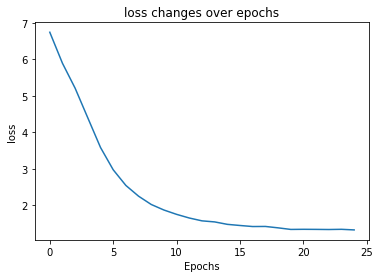

In [85]:
plot_graphs(history, 'loss')

The above graph shows that as the number of epoch increases, the training losses have been decreasing first rapidly then steadily. When it approaches 25 epochs, the losses are becoming stable.

In [12]:
print(text_generator('i was home', 100, tokenizer, model_1, max_sequence_len))

i was home and bastards for the ever time in alone from hung when i was still tired and i would desk a nick libra look lazing on an ones comming and until use reach late out of the fat and college watched a shows is going to day utilize and her until the is off the send sign in a called and a better contrasted to emo answered and seeing to my house forward i was just ovulation about i had my married a did for me and i without to bad 45 stand and give the easy hear the slow i


Compared to the text generated before, the one output by the tuned model hasn't shown problems of repeating words. Moreover, some phrases can be observed in the block of text. However, it appears that the text doesn't make much sense as sentence structures are still missing.